In [4]:
import sklearn.datasets
import sklearn.metrics
import sklearn.model_selection
import pandas as pd

# From OpenML: https://www.openml.org/search?type=data&status=active&id=43672
dataset_name = "Heart-Disease-Dataset-(Comprehensive)"


def get_data_and_scoring_function(dataset_name):
    X, y = sklearn.datasets.fetch_openml(dataset_name, as_frame=True, return_X_y=True)
    X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
        X,
        y,
        random_state=0,
        stratify=y,
    )

    def scoring_function(estimator):
        predictions = estimator.predict_proba(X_test)[:, 1]
        return sklearn.metrics.roc_auc_score(y_test, predictions)

    def train_scoring_function(estimator):
        predictions = estimator.predict_proba(X_train)[:, 1]
        return sklearn.metrics.roc_auc_score(y_train, predictions)

    def get_test_data():
        return X_test, y_test

    return (
        X,
        y,
        X_train,
        y_train,
        get_test_data,
        scoring_function,
        train_scoring_function,
    )


X, y, X_train, y_train, get_test_data, scoring_function, train_scoring_function = (
    get_data_and_scoring_function(dataset_name)
)

X_test, y_test = get_test_data()

print(f"Done Processing and downloading {dataset_name}")

# Define the directory and save the dataset
output_directory = "dataset"
train_data = pd.concat([X_train, y_train], axis=1)
train_data.to_csv(f"{output_directory}/train.csv", index=False)

# Combine the features and target variable for the testing set
test_data = pd.concat([X_test, y_test], axis=1)
test_data.to_csv(f"{output_directory}/test.csv", index=False)

# Combine the features and target variable for the complete dataset
complete_data = pd.concat([X, y], axis=1)
complete_data.to_csv(f"{output_directory}/complete_dataset.csv", index=False)

Done Processing and downloading Heart-Disease-Dataset-(Comprehensive)


/home/skhani/anaconda3/envs/ag/lib/python3.10/site-packages/sklearn/datasets/_openml.py:322: UserWarning: Multiple active versions of the dataset matching the name heart-disease-dataset-(comprehensive) exist. Versions may be fundamentally different, returning version 1. Available versions:
- version 1, status: active
  url: https://www.openml.org/search?type=data&id=43672
- version 2, status: active
  url: https://www.openml.org/search?type=data&id=43682

  warn(warning_msg)


In [8]:
import pandas as pd

class_counts = complete_data["target"].value_counts()
print(f"Class counts:\n{class_counts}")

Class counts:
target
1.0    629
0.0    561
Name: count, dtype: int64


Accuracy: 0.8322147651006712
Confusion Matrix:
[[114  26]
 [ 24 134]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.83      0.81      0.82       140
         1.0       0.84      0.85      0.84       158

    accuracy                           0.83       298
   macro avg       0.83      0.83      0.83       298
weighted avg       0.83      0.83      0.83       298



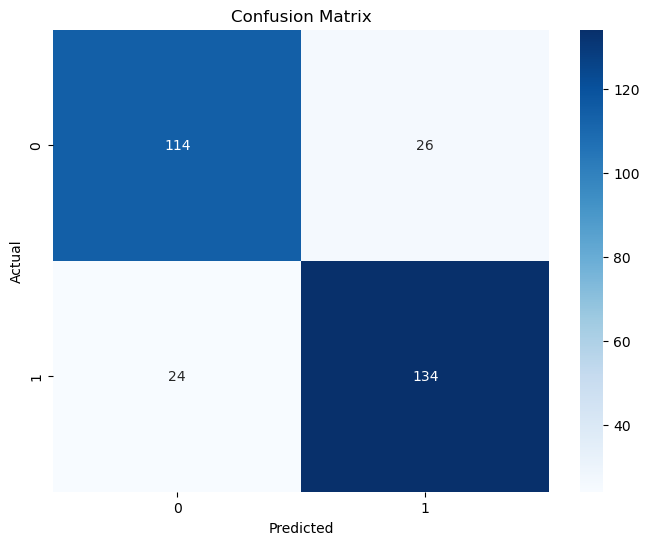

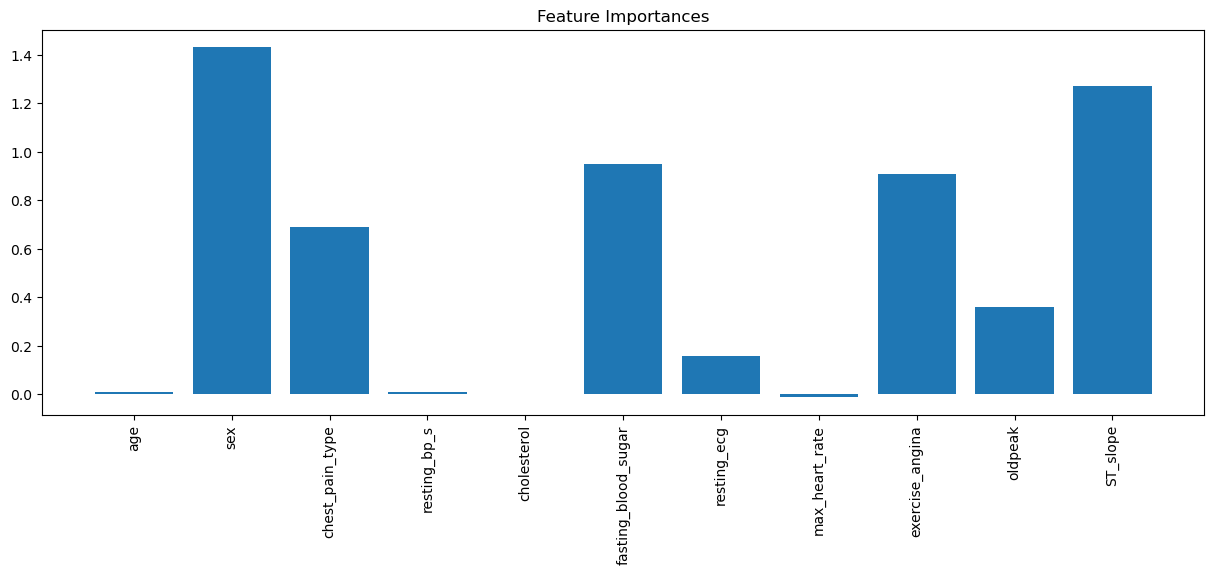

,Odds Ratio
age,1.008021
sex,4.178571
chest_pain_type,1.987779
resting_bp_s,1.009353
cholesterol,0.998620
fasting_blood_sugar,2.579561
resting_ecg,1.167711
max_heart_rate,0.986702
exercise_angina,2.477219
oldpeak,1.428848


In [9]:
# Basic logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

lr = LogisticRegression(
    penalty="l2",
    C=1.0,
    fit_intercept=True,
    class_weight="balanced",
    random_state=42,
    solver="lbfgs",
    max_iter=1000,
    multi_class="auto",
    warm_start=False,
    n_jobs=-1,
)
lr.fit(X_train, y_train)

# predict on the test set with custom probabilities
y_pred_proba = lr.predict_proba(X_test)

# Use threshold of 0.7 for positive class
threshold = 0.5
y_pred = (y_pred_proba[:, 1] >= threshold).astype("int")


# accuracy, confusion matrix, and classification report
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

# plot confusion matrix
confusion_mat = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# plot feature importance
importance = lr.coef_[0]
plt.figure(figsize=(15, 5))
plt.bar([x for x in range(len(importance))], importance)
plt.title("Feature Importances")
plt.xticks(np.arange(len(X.columns)), X.columns, rotation="vertical")
plt.show()

# calculate the odds ratio
odds_ratios = np.exp(lr.coef_)[0]
pd.DataFrame(odds_ratios, X.columns, columns=["Odds Ratio"])

In [12]:
from autogluon.tabular import TabularDataset, TabularPredictor

# Load the training data
train_data = TabularDataset("dataset/train.csv")
train_data.head()

# Label column
label = "target"
train_data[label].describe()

# Fit the model
predictor = TabularPredictor(
    label=label,
    problem_type="binary",
    eval_metric="log_loss",
    log_to_file=True,
).fit(
    train_data,
    time_limit=10 * 60,
    presets="best_quality",
    num_gpus=1,
)

No path specified. Models will be saved in: "AutogluonModels/ag-20240304_092424"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
Dynamic stacking is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
Detecting stacked overfitting by sub-fitting AutoGluon on the input data. That is, copies of AutoGluon will be sub-fit on subset(s) of the data. Then, the holdout validation data is used to detect stacked overfitting.
Sub-fit(s) time limit is: 600 seconds.
Starting holdout-based sub-fit for dynamic stacking. Context path is: AutogluonModels/ag-20240304_092424/ds_sub_fit/sub_fit_ho.
Beginning AutoGluon training ... Time limit = 150s
AutoGluon will save models to "AutogluonModels/ag-20240304_092424/ds_sub_fit/sub_fit_ho"
=================== System Info ===================
AutoGluon Version:  1.0

[1000]	valid_set's binary_logloss: 0.20161


	-0.293	 = Validation score   (-log_loss)
	1.47s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: RandomForestGini_BAG_L1 ... Training model for up to 96.17s of the 146.18s of remaining time.
	-0.3107	 = Validation score   (-log_loss)
	0.35s	 = Training   runtime
	0.05s	 = Validation runtime
Fitting model: RandomForestEntr_BAG_L1 ... Training model for up to 95.71s of the 145.71s of remaining time.
	-0.273	 = Validation score   (-log_loss)
	0.3s	 = Training   runtime
	0.05s	 = Validation runtime
Fitting model: CatBoost_BAG_L1 ... Training model for up to 95.32s of the 145.33s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	-0.2777	 = Validation score   (-log_loss)
	2.86s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: ExtraTreesGini_BAG_L1 ... Training model for up to 92.41s of the 142.42s of remaining time.
	-0.2652	 = Validation score   (-log_loss)
	0.28s	 = Training   runtime
	0.05s	 = Val

[1000]	valid_set's binary_logloss: 0.159486


	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
No improvement since epoch 18: early stopping
No improvement since epoch 13: early stopping
No improvement since epoch 6: early stopping
No improvement since epoch 6: early stopping
No improvement since epoch 13: early stopping
No improvement since epoch 3: early stopping
No improvement since epoch 9: early stopping
No improvement since epoch 11: early stopping
	-0.3437	 = Validation score   (-log_loss)
	3.56s	 = Training   runtime
	0.03s	 = Validation runtime
Fitting model: CatBoost_r9_BAG_L1 ... Training model for up to 55.6s of the 105.6s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	-0.2653	 = Validation score   (-log_loss)
	6.41s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: LightGBM_r96_BAG_L1 ... Training model for up to 49.1s of the 99.11s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with 

[1000]	valid_set's binary_logloss: 0.404971
[2000]	valid_set's binary_logloss: 0.393404
[3000]	valid_set's binary_logloss: 0.382934
[4000]	valid_set's binary_logloss: 0.3685
[5000]	valid_set's binary_logloss: 0.3578
[6000]	valid_set's binary_logloss: 0.346805
[7000]	valid_set's binary_logloss: 0.340061
[8000]	valid_set's binary_logloss: 0.33327
[9000]	valid_set's binary_logloss: 0.327393
[10000]	valid_set's binary_logloss: 0.32231
[1000]	valid_set's binary_logloss: 0.321664
[2000]	valid_set's binary_logloss: 0.311385
[3000]	valid_set's binary_logloss: 0.309965
[1000]	valid_set's binary_logloss: 0.407056
[2000]	valid_set's binary_logloss: 0.387335
[3000]	valid_set's binary_logloss: 0.382006
[4000]	valid_set's binary_logloss: 0.38053
[5000]	valid_set's binary_logloss: 0.384124
[1000]	valid_set's binary_logloss: 0.390142
[1000]	valid_set's binary_logloss: 0.335857
[2000]	valid_set's binary_logloss: 0.325137
[3000]	valid_set's binary_logloss: 0.320238
[1000]	valid_set's binary_logloss: 0.4

	-0.3473	 = Validation score   (-log_loss)
	4.5s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: NeuralNetTorch_r22_BAG_L1 ... Training model for up to 44.25s of the 94.26s of remaining time.


[10000]	valid_set's binary_logloss: 0.203474


	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	-0.3263	 = Validation score   (-log_loss)
	10.34s	 = Training   runtime
	0.03s	 = Validation runtime
Fitting model: XGBoost_r33_BAG_L1 ... Training model for up to 33.78s of the 83.78s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	-0.2678	 = Validation score   (-log_loss)
	1.65s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: ExtraTrees_r42_BAG_L1 ... Training model for up to 32.0s of the 82.01s of remaining time.
	-0.2679	 = Validation score   (-log_loss)
	0.3s	 = Training   runtime
	0.05s	 = Validation runtime
Fitting model: CatBoost_r137_BAG_L1 ... Training model for up to 31.59s of the 81.59s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	-0.2962	 = Validation score   (-log_loss)
	6.42s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: Neur

[1000]	valid_set's binary_logloss: 0.128865


	-0.2817	 = Validation score   (-log_loss)
	2.82s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: NeuralNetFastAI_r191_BAG_L1 ... Training model for up to 252.47s of the 401.86s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
No improvement since epoch 6: early stopping
No improvement since epoch 21: early stopping
No improvement since epoch 14: early stopping
No improvement since epoch 5: early stopping
No improvement since epoch 4: early stopping
No improvement since epoch 4: early stopping
No improvement since epoch 2: early stopping
No improvement since epoch 4: early stopping
	-0.3443	 = Validation score   (-log_loss)
	4.28s	 = Training   runtime
	0.03s	 = Validation runtime
Fitting model: CatBoost_r9_BAG_L1 ... Training model for up to 247.99s of the 397.38s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	-0.2593	 = Validation score   (-log_loss

[1000]	valid_set's binary_logloss: 0.385577
[2000]	valid_set's binary_logloss: 0.376476
[3000]	valid_set's binary_logloss: 0.372772
[4000]	valid_set's binary_logloss: 0.367982
[5000]	valid_set's binary_logloss: 0.371529
[1000]	valid_set's binary_logloss: 0.312199
[2000]	valid_set's binary_logloss: 0.294579
[3000]	valid_set's binary_logloss: 0.284661
[4000]	valid_set's binary_logloss: 0.274779
[5000]	valid_set's binary_logloss: 0.26843
[6000]	valid_set's binary_logloss: 0.26451
[7000]	valid_set's binary_logloss: 0.259823
[8000]	valid_set's binary_logloss: 0.254505
[9000]	valid_set's binary_logloss: 0.251937
[10000]	valid_set's binary_logloss: 0.250229
[1000]	valid_set's binary_logloss: 0.333509
[2000]	valid_set's binary_logloss: 0.323339
[3000]	valid_set's binary_logloss: 0.312103
[4000]	valid_set's binary_logloss: 0.305449
[5000]	valid_set's binary_logloss: 0.299878
[6000]	valid_set's binary_logloss: 0.295517
[7000]	valid_set's binary_logloss: 0.291159
[8000]	valid_set's binary_logloss

	-0.3441	 = Validation score   (-log_loss)
	4.42s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: NeuralNetTorch_r22_BAG_L1 ... Training model for up to 236.08s of the 385.47s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy


[1000]	valid_set's binary_logloss: 0.401997


	-0.3224	 = Validation score   (-log_loss)
	11.4s	 = Training   runtime
	0.03s	 = Validation runtime
Fitting model: XGBoost_r33_BAG_L1 ... Training model for up to 224.53s of the 373.93s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	-0.2585	 = Validation score   (-log_loss)
	1.86s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: ExtraTrees_r42_BAG_L1 ... Training model for up to 222.53s of the 371.92s of remaining time.
	-0.2764	 = Validation score   (-log_loss)
	0.3s	 = Training   runtime
	0.05s	 = Validation runtime
Fitting model: CatBoost_r137_BAG_L1 ... Training model for up to 222.1s of the 371.5s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 9244.
	-0.2842	 = Validation score   (-log_loss)
	29.35s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: NeuralNetFastAI_r102_BAG_L1 ... Tra

[1000]	valid_set's binary_logloss: 0.15175


	-0.2884	 = Validation score   (-log_loss)
	1.53s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: NeuralNetTorch_r86_BAG_L1 ... Training model for up to 131.43s of the 280.82s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	-0.313	 = Validation score   (-log_loss)
	7.06s	 = Training   runtime
	0.03s	 = Validation runtime
Fitting model: CatBoost_r50_BAG_L1 ... Training model for up to 124.19s of the 273.59s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	-0.2785	 = Validation score   (-log_loss)
	2.84s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: NeuralNetFastAI_r11_BAG_L1 ... Training model for up to 121.28s of the 270.67s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
No improvement since epoch 2: early stopping
No improvement since epoch 10: early stopping
No improveme

[1000]	valid_set's binary_logloss: 0.120436


	-0.269	 = Validation score   (-log_loss)
	3.4s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: NeuralNetFastAI_r143_BAG_L1 ... Training model for up to 97.88s of the 247.28s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
No improvement since epoch 16: early stopping
No improvement since epoch 13: early stopping
No improvement since epoch 1: early stopping
	-0.3435	 = Validation score   (-log_loss)
	23.97s	 = Training   runtime
	0.05s	 = Validation runtime
Fitting model: CatBoost_r70_BAG_L1 ... Training model for up to 73.69s of the 223.08s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	-0.2587	 = Validation score   (-log_loss)
	4.32s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: NeuralNetFastAI_r156_BAG_L1 ... Training model for up to 69.28s of the 218.67s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with S

[1000]	valid_set's binary_logloss: 0.372061
[2000]	valid_set's binary_logloss: 0.338364
[3000]	valid_set's binary_logloss: 0.331041
[1000]	valid_set's binary_logloss: 0.302628
[2000]	valid_set's binary_logloss: 0.249705
[3000]	valid_set's binary_logloss: 0.22368
[4000]	valid_set's binary_logloss: 0.210407
[5000]	valid_set's binary_logloss: 0.202952
[6000]	valid_set's binary_logloss: 0.1993
[7000]	valid_set's binary_logloss: 0.198648
[8000]	valid_set's binary_logloss: 0.202422
[1000]	valid_set's binary_logloss: 0.311602
[2000]	valid_set's binary_logloss: 0.260481
[3000]	valid_set's binary_logloss: 0.238835
[4000]	valid_set's binary_logloss: 0.232087
[5000]	valid_set's binary_logloss: 0.228376
[6000]	valid_set's binary_logloss: 0.231792
[1000]	valid_set's binary_logloss: 0.31581
[1000]	valid_set's binary_logloss: 0.379006
[2000]	valid_set's binary_logloss: 0.364548
[3000]	valid_set's binary_logloss: 0.360798
[4000]	valid_set's binary_logloss: 0.366539
[1000]	valid_set's binary_logloss: 0

	-0.3168	 = Validation score   (-log_loss)
	8.28s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: RandomForest_r39_BAG_L1 ... Training model for up to 40.69s of the 190.09s of remaining time.


[1000]	valid_set's binary_logloss: 0.418695


	-0.2994	 = Validation score   (-log_loss)
	0.36s	 = Training   runtime
	0.05s	 = Validation runtime
Fitting model: CatBoost_r167_BAG_L1 ... Training model for up to 40.17s of the 189.56s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	-0.2587	 = Validation score   (-log_loss)
	2.77s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: NeuralNetFastAI_r95_BAG_L1 ... Training model for up to 37.34s of the 186.73s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
No improvement since epoch 3: early stopping
No improvement since epoch 8: early stopping
No improvement since epoch 3: early stopping
No improvement since epoch 2: early stopping
No improvement since epoch 2: early stopping
No improvement since epoch 2: early stopping
No improvement since epoch 2: early stopping
No improvement since epoch 2: early stopping
	-0.3296	 = Validation score   (-log_loss)
	

[1000]	valid_set's binary_logloss: 0.191461


	-0.2243	 = Validation score   (-log_loss)
	1.94s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: NeuralNetTorch_r22_BAG_L2 ... Training model for up to 75.55s of the 75.47s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	-0.2035	 = Validation score   (-log_loss)
	8.42s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: XGBoost_r33_BAG_L2 ... Training model for up to 66.95s of the 66.88s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	-0.2248	 = Validation score   (-log_loss)
	3.43s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: ExtraTrees_r42_BAG_L2 ... Training model for up to 63.39s of the 63.32s of remaining time.
	-0.2817	 = Validation score   (-log_loss)
	0.32s	 = Training   runtime
	0.05s	 = Validation runtime
Fitting model: CatBoost_r137_BAG_L2 ... Training model for up to 62.93s of the 62.86s of remaining ti

In [13]:
test_data = TabularDataset("dataset/test.csv")
# Label column
label = "target"
y_pred = predictor.predict(
    test_data.drop(columns=[label]),
    decision_threshold=0.2,
)
y_pred.head()

Loaded data from: /home/skhani/Documents/Recent/PV/AutoML/exam/Heart_Disease/dataset/test.csv | Columns = 12 / 12 | Rows = 298 -> 298


0    1.0
1    1.0
2    0.0
3    0.0
4    1.0
Name: target, dtype: float64

In [15]:
from sklearn.metrics import classification_report

print(classification_report(test_data[label], y_pred, digits=4))

              precision    recall  f1-score   support

         0.0     0.9323    0.8857    0.9084       140
         1.0     0.9030    0.9430    0.9226       158

    accuracy                         0.9161       298
   macro avg     0.9177    0.9144    0.9155       298
weighted avg     0.9168    0.9161    0.9159       298



In [12]:
# Calculate feature importance
importance = predictor.feature_importance(train_data)

# Print feature importance
print(importance)

Computing feature importance via permutation shuffling for 11 features using 892 rows with 5 shuffle sets...
	327.01s	= Expected runtime (65.4s per shuffle set)
	174.88s	= Actual runtime (Completed 5 of 5 shuffle sets)


                     importance    stddev       p_value  n  p99_high   p99_low
ST_slope               0.258898  0.010726  3.527366e-07  5  0.280983  0.236813
chest_pain_type        0.132126  0.017245  3.404543e-05  5  0.167633  0.096619
max_heart_rate         0.100305  0.008151  5.187012e-06  5  0.117088  0.083522
cholesterol            0.093575  0.008852  9.498057e-06  5  0.111802  0.075348
resting_bp_s           0.078325  0.005586  3.082885e-06  5  0.089826  0.066824
oldpeak                0.075701  0.007279  1.013061e-05  5  0.090688  0.060714
age                    0.060270  0.005144  6.305607e-06  5  0.070862  0.049679
sex                    0.055886  0.003298  1.447878e-06  5  0.062675  0.049096
exercise_angina        0.034623  0.002071  1.527521e-06  5  0.038887  0.030360
resting_ecg            0.026585  0.003244  2.608971e-05  5  0.033265  0.019905
fasting_blood_sugar    0.020442  0.001950  9.824808e-06  5  0.024457  0.016426


In [13]:
predictor.leaderboard(test_data)

,model,score_test,score_val,eval_metric,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,XGBoost_r98_BAG_L1,-0.244360,-0.262646,log_loss,0.170385,0.029805,3.698964,0.170385,0.029805,3.698964,1,True,49
1,LightGBM_r161_BAG_L1,-0.244943,-0.269033,log_loss,0.059372,0.017256,3.637606,0.059372,0.017256,3.637606,1,True,40
2,NeuralNetFastAI_r102_BAG_L2,-0.245493,-0.208665,log_loss,3.779642,1.419683,308.410562,0.199010,0.055073,18.606121,2,True,74
3,CatBoost_r13_BAG_L1,-0.246146,-0.252958,log_loss,0.090549,0.009624,15.421703,0.090549,0.009624,15.421703,1,True,25
4,RandomForestEntr_BAG_L2,-0.246501,-0.282433,log_loss,3.652318,1.422075,290.111734,0.071686,0.057465,0.307293,2,True,56
...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,NeuralNetTorch_r158_BAG_L1,-0.352519,-0.331075,log_loss,0.071456,0.039449,8.007262,0.071456,0.039449,8.007262,1,True,51
74,NeuralNetFastAI_r143_BAG_L1,-0.354761,-0.343471,log_loss,0.202200,0.056150,24.671056,0.202200,0.056150,24.671056,1,True,41
75,ExtraTrees_r42_BAG_L2,-0.387594,-0.257851,log_loss,3.632497,1.413326,290.123708,0.051865,0.048715,0.319267,2,True,72
76,KNeighborsDist_BAG_L1,-1.010155,-0.908844,log_loss,0.037683,0.014588,0.003561,0.037683,0.014588,0.003561,1,True,2
